# Practical Lab 3 – Vanilla CNN and Fine-Tune VGG16  
## Dogs vs Cats Classification

**Student Name:** Maduka Albright Ifechukwude  
**Student ID:** 9053136  
**Course Code:** CSCN 8010

---

### **Lab Objectives**

In this lab, I will:

1. Use the small Dogs vs Cats image dataset (~5000 images) provided in the course.
2. Perform Exploratory Data Analysis (EDA) with appropriate graphs, statistics, and insights.
3. Build and train a **vanilla Convolutional Neural Network (CNN)** from scratch.
4. Fine-tune a **pre-trained VGG16 model** (transfer learning using ImageNet weights).
5. Save and load the best-performing model versions using **callbacks**.
6. Compare both models using the following metrics:
   - Accuracy  
   - Confusion Matrix  
   - Precision, Recall, F1-score  
   - Precision–Recall Curve  
7. Analyze samples where the models made incorrect predictions.
8. Summarize key conclusions about:
   - Model performance  
   - Overfitting  
   - Benefits of transfer learning  
   - Recommendations for improvement  


## 1. Imports, Configuration, and Paths

**Explanation:**

This section loads all required libraries, sets the random seeds for reproducibility,  
and defines the paths for the dataset and model checkpoint directory.

In [1]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    average_precision_score
)
import itertools

print("TensorFlow version:", tf.__version__)

# Reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Paths (relative to this notebook)
BASE_DIR = Path("data/kaggle_dogs_vs_cats_small")
MODELS_DIR = Path("models_lab3")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Dataset parameters
IMG_SIZE = (150, 150) # height, width
BATCH_SIZE = 32 # per GPU


TensorFlow version: 2.15.0
TensorFlow version: 2.15.0


## 2. Dataset size and splits

**Explanation:**

I used the 5,000-image subset of the Dogs vs Cats dataset, split into 2,000 training images, 1,000 validation images, and 2,000 test images across the two classes.

In [2]:
# Training dataset
train_ds = image_dataset_from_directory( 
    BASE_DIR / "train", # training data directory
    image_size=IMG_SIZE, # image size
    batch_size=BATCH_SIZE, # batch size
    shuffle=True, # shuffle the data
    seed=SEED # random seed for shuffling and transformations
)

# Validation dataset
val_ds = image_dataset_from_directory(
    BASE_DIR / "validation", # validation data directory
    image_size=IMG_SIZE, # image size
    batch_size=BATCH_SIZE, # batch size
    shuffle=False # do not shuffle validation data
)
# Test dataset
test_ds = image_dataset_from_directory(
    BASE_DIR / "test", #1 test data directory
    image_size=IMG_SIZE, # image size
    batch_size=BATCH_SIZE, # batch size
    shuffle=False # do not shuffle test data
)

# class names
class_names = train_ds.class_names # get class names
print("Classes:", class_names) # print class names

# performance optimizations
AUTOTUNE = tf.data.AUTOTUNE # autotune parameter
train_ds = train_ds.prefetch(AUTOTUNE) # prefetch training dataset
val_ds   = val_ds.prefetch(AUTOTUNE) # prefetch validation dataset
test_ds  = test_ds.prefetch(AUTOTUNE) # prefetch test dataset

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Classes: ['cat', 'dog']
Classes: ['cat', 'dog']


**Reflection:**

The dataset is evenly balanced between cats and dogs, giving a fair and unbiased foundation for training. Because there is no class imbalance, any performance difference between the Vanilla CNN and the Fine-Tuned VGG16 reflects the model architecture and learning capacity, not dataset bias.

## 3. Exploratory Data Analysis (EDA)

### 3.1 Class Distribution

**Explanation:**

I examine the class distribution and some sample images.
This helps me understand potential challenges (lighting variation, backgrounds, imbalance, etc.)  
and confirms the dataset is correctly loaded.

Train: {'cat': 1000, 'dog': 1000}
Validation:   {'cat': 500, 'dog': 500}
Test:  {'cat': 1000, 'dog': 1000}


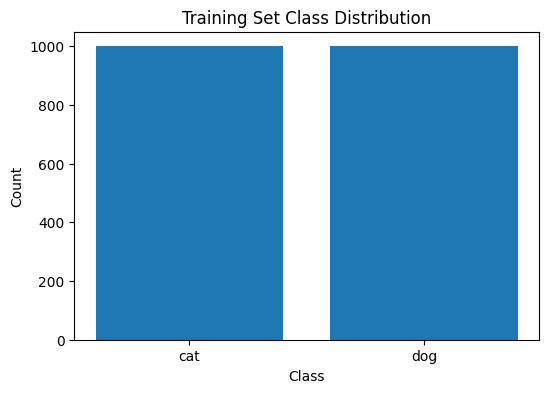

In [3]:
# Function to get class counts
def get_class_counts(dataset):
    counts = {name: 0 for name in class_names} # initialize counts
    for images, labels in dataset: # iterate over dataset
        for l in labels.numpy(): # iterate over labels in batch
            counts[class_names[l]] += 1 # increment count for class
    return counts # return counts

# Get class distributions
train_counts = get_class_counts(train_ds) # get training set class counts
val_counts   = get_class_counts(val_ds)   # get validation set class counts
test_counts  = get_class_counts(test_ds)  # get test set class counts

# Print class distributions
print("Train:", train_counts) # print training set class distribution
print("Validation:  ", val_counts) # print validation set class distribution
print("Test: ", test_counts) # print test set class distribution

# Plot training set class distribution
plt.figure(figsize=(6,4)) # create figure
plt.bar(train_counts.keys(), train_counts.values()) # plot bar chart
plt.title("Training Set Class Distribution") # set title
plt.xlabel("Class") # set x-axis label
plt.ylabel("Count") # set y-axis label
plt.show() # display plot

**Reflection:**

The training, validation, and test sets each show an equal number of cat and dog images
(e.g., Train: 1000 each, Validation: 500 each, Test: 1000 each).
This perfect balance ensures the models learn from both classes equally, making performance
differences between the Vanilla CNN and VGG16 due to model capability, not class imbalance.

### 3.2 Sample Images and Basic Stats

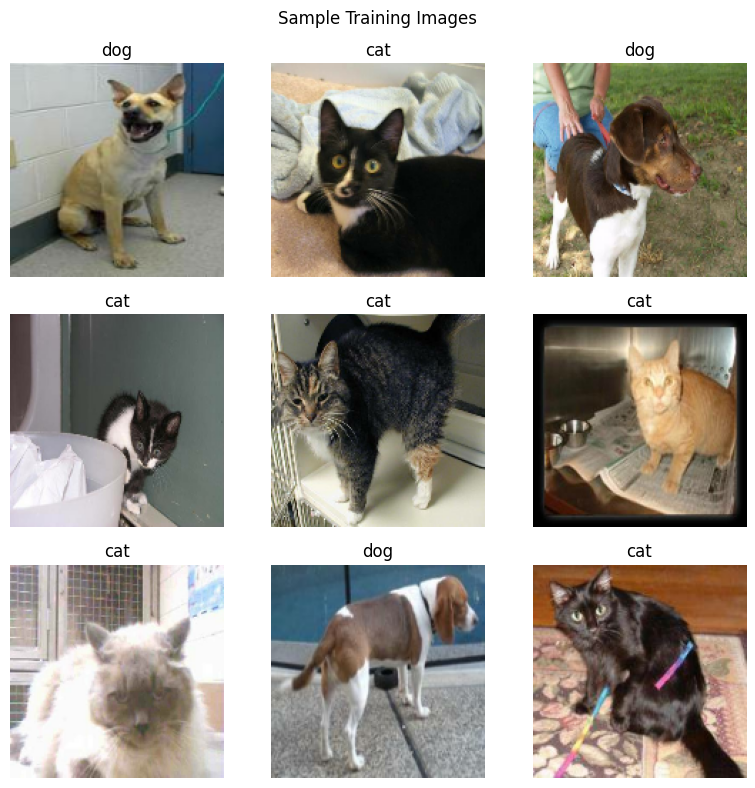

Image batch shape: (32, 150, 150, 3)
Label batch shape: (32,)
Pixel range: 0.0 to 255.0


In [4]:
# Plot sample images from training set
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1): # take a single batch
    for i in range(9): # display 9 images
        ax = plt.subplot(3, 3, i + 1) # display images in 3x3 grid
        plt.imshow(images[i].numpy().astype("uint8")) # display image
        plt.title(class_names[labels[i]]) # display class name
        plt.axis("off") # display axis off
plt.suptitle("Sample Training Images") # display suptitle
plt.tight_layout() # adjust subplots to fit into figure area.
plt.show() # show the figure

# Basic shape & pixel range
for images, labels in train_ds.take(1): # take a single batch
    print("Image batch shape:", images.shape) # display image batch shape
    print("Label batch shape:", labels.shape) # display label batch shape
    print("Pixel range:", images.numpy().min(), "to", images.numpy().max()) # display pixel range

**Reflection:**

The sample images show natural variation in lighting, pose, background, and image quality, which helps the models learn more robust features. The shapes (32, 150, 150, 3) and pixel range 0–255 confirm that the dataset is correctly formatted for CNN input, and that normalization is required before training.

### 3.3 Image Size Consistency

**Explanation:**

To verify dataset consistency, I check whether all images load to the same resized shape (150×150×3). This ensures that no corrupted or irregular images affect model training.


In [5]:
# Check image shapes across a few batches
shapes = set() # initialize empty set for shapes

for images, labels in train_ds.take(5): # take 5 batches
    shapes.add(images.shape) # add image shape to set

shapes # display unique image shapes

{TensorShape([32, 150, 150, 3])}

**Reflection:**  

All sampled batches show the same image shape (150×150×3), confirming that the dataset was loaded and resized correctly. This consistency prevents runtime errors and ensures smooth training for both CNN models.

### 3.4 Pixel Value Histogram

**Explanation:**

To better understand the raw image intensity distribution, I plot a histogram of pixel values from a sample batch. This helps confirm normalization needs and identify any unusual pixel distortions.


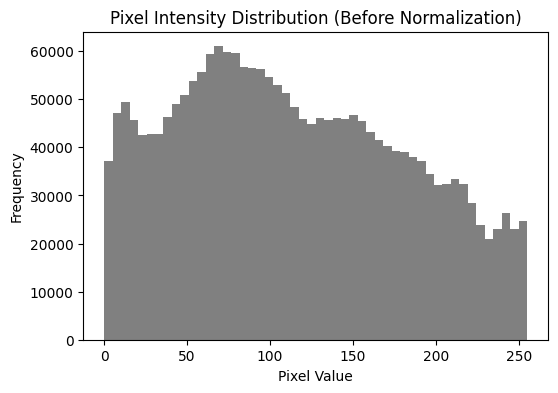

In [6]:
# Take one batch of images
for images, labels in train_ds.take(1): # take a single batch
    sample_images = images.numpy().flatten() # flatten images to 1D array
    break   # exit loop after first batch

plt.figure(figsize=(6,4)) # create figure for histogram
plt.hist(sample_images, bins=50, color="gray") # plot histogram of pixel intensities
plt.title("Pixel Intensity Distribution (Before Normalization)") # set title
plt.xlabel("Pixel Value") # set x-axis label
plt.ylabel("Frequency") # set y-axis label
plt.show() # display histogram

**Reflection:**  

The wide pixel-value range (0–255) shows significant variation in lighting and contrast across the dataset. This diversity helps the model learn more robust features, but also makes normalization an important preprocessing step for stable and efficient training.

## 4. Data Pipeline and Augmentation

**Explanation:**

To improve generalization and reduce overfitting, both models use the same data-augmentation pipeline. Random flips, rotations, and zoom operations increase the variability of the training data, helping both models learn more robust and invariant features.

In [7]:
# Data augmentation layer
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"), # horizontal flip
        layers.RandomRotation(0.1), # random rotation
        layers.RandomZoom(0.1), # random zoom
    ],
    name="data_augmentation" # name the layer
)

## 5. Model 1 (Vanilla CNN)

### 5.1 Define the CNN

**Explanation:**

This model is built manually using convolution, pooling, and dense layers.  
It trains from scratch and serves as a baseline for comparison with VGG16.

In [8]:
# Vanilla CNN model definition
def create_vanilla_cnn(input_shape=IMG_SIZE + (3,)): # define function
    inputs = keras.Input(shape=input_shape) # input layer
    
    x = data_augmentation(inputs) # data augmentation layer
    x = layers.Rescaling(1./255)(x) # rescaling layer
    
    x = layers.Conv2D(32, (3,3), activation="relu")(x) # first convolutional layer
    x = layers.MaxPooling2D((2,2))(x) # first max pooling layer
    
    x = layers.Conv2D(64, (3,3), activation="relu")(x) # second convolutional layer
    x = layers.MaxPooling2D((2,2))(x) # second max pooling layer
    
    x = layers.Conv2D(128, (3,3), activation="relu")(x) # third convolutional layer
    x = layers.MaxPooling2D((2,2))(x) # third max pooling layer
    
    x = layers.Flatten()(x) # flatten layer
    x = layers.Dense(128, activation="relu")(x) # fully connected layer
    x = layers.Dropout(0.5)(x) # dropout layer
    outputs = layers.Dense(1, activation="sigmoid")(x) # output layer
    
    model = keras.Model(inputs, outputs, name="vanilla_cnn") # create model
    return model # return model

vanilla_model = create_vanilla_cnn() # create vanilla CNN model
vanilla_model.summary() # print model summary


Model: "vanilla_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 150, 150, 3)       0         
 ial)                                                            
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)       

**Reflection:**

The Vanilla CNN uses standard convolution, pooling, and dense layers, with about 4828481 trainable parameters.
It provides a simple baseline model, but training from scratch means it will likely perform worse than VGG16 transfer learning.

### 5.2 Compile and Callbacks (save best model)

**Explanation:**  

The Vanilla CNN is compiled using the Adam optimizer and binary cross-entropy, which is standard for binary classification.  
ModelCheckpoint saves the best-performing model, while EarlyStopping prevents overfitting by stopping when validation loss stops improving.


In [9]:
# Compile the model
vanilla_model.compile( # compile the model
    optimizer=keras.optimizers.Adam(1e-4), # Adam optimizer with learning rate 1e-4
    loss="binary_crossentropy", # binary crossentropy loss for binary classification
    metrics=["accuracy"] # accuracy metric
)

# Callbacks
vanilla_ckpt_path = MODELS_DIR / "vanilla_cnn_best.keras" # checkpoint path

callbacks_vanilla = [ # callbacks for training
    keras.callbacks.ModelCheckpoint( # model checkpoint callback
        filepath=str(vanilla_ckpt_path), # filepath to save the model
        monitor="val_accuracy", # monitor validation accuracy
        mode="max", # mode is maximize
        save_best_only=True, # save only the best model
        verbose=1 # verbosity level
    ),
    keras.callbacks.EarlyStopping( # early stopping callback
        monitor="val_loss", # monitor validation loss
        mode="min", # mode is minimize
        patience=5, # patience of 5 epochs
        verbose=1, # verbosity level
        restore_best_weights=True # restore best weights after stopping
    )
]

**Reflection:**
 
Using callbacks such as ModelCheckpoint and EarlyStopping helps stabilize training and ensures that the final saved model represents the best validation performance. This makes the training process more efficient and prevents unnecessary overfitting.


### 5.3 Train and Plot

Epoch 1/30




63/63 [==============================] - ETA: 0s - loss: 0.7025 - accuracy: 0.5150
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to models_lab3\vanilla_cnn_best.keras

Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to models_lab3\vanilla_cnn_best.keras
63/63 [==============================] - 20s 291ms/step - loss: 0.7025 - accuracy: 0.5150 - val_loss: 0.6905 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 20s 291ms/step - loss: 0.7025 - accuracy: 0.5150 - val_loss: 0.6905 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 0.6863 - accuracy: 0.5440
Epoch 2: val_accuracy improved from 0.50000 to 0.54500, saving model to models_lab3\vanilla_cnn_best.keras

Epoch 2: val_accuracy improved from 0.50000 to 0.54500, saving model to models_lab3\vanilla_cnn_best.keras
63/63 [==============================] - 18s 284ms/step - loss: 0.6863 - accuracy: 0.5440 - val_loss: 0.6765 

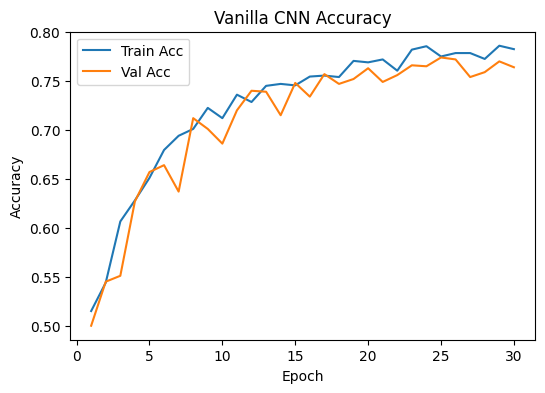

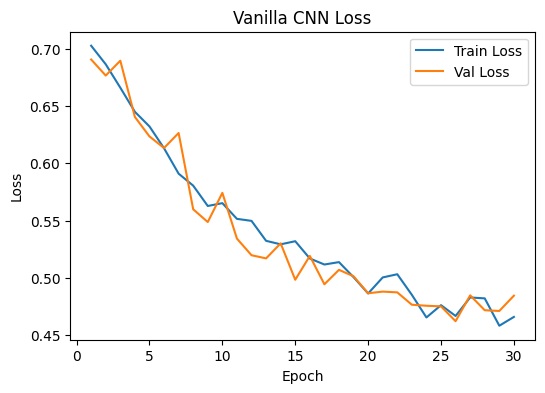

In [10]:
# Train the vanilla CNN
history_vanilla = vanilla_model.fit( # train the vanilla CNN model
    train_ds, # training dataset
    validation_data=val_ds, # validation dataset
    epochs=30, # number of epochs
    callbacks=callbacks_vanilla # callbacks for training
)
# Define function to plot accuracy and loss
def plot_history(history, title_prefix=""):
    acc = history.history["accuracy"] # training accuracy
    val_acc = history.history["val_accuracy"] # validation accuracy
    loss = history.history["loss"] # training loss
    val_loss = history.history["val_loss"] # validation loss
    epochs = range(1, len(acc) + 1) # epoch range

# Plot accuracy
    plt.figure(figsize=(6,4)) 
    plt.plot(epochs, acc, label="Train Acc") # training accuracy
    plt.plot(epochs, val_acc, label="Val Acc") # validation accuracy
    plt.title(f"{title_prefix} Accuracy") # plot title
    plt.xlabel("Epoch") # xlabel
    plt.ylabel("Accuracy") # ylabel
    plt.legend()
    plt.show()

# Plot loss
    plt.figure(figsize=(6,4)) # figure size
    plt.plot(epochs, loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.title(f"{title_prefix} Loss") # plot title
    plt.xlabel("Epoch") # xlabel
    plt.ylabel("Loss") # ylabel
    plt.legend()
    plt.show()

# Call the function to plot
plot_history(history_vanilla, "Vanilla CNN")

**Reflection:**

The Vanilla CNN shows steady improvement but begins overfitting after several epochs, as training accuracy continues rising while validation accuracy fluctuates. Early stopping restores the best weights around epoch 25, showing that the model learns meaningful features but still struggles with generalization compared to deeper pretrained models like VGG16.

## 6. Model 2 (Fine-Tuned VGG16)

**Explanation:**

This model uses the VGG16 architecture pre-trained on ImageNet, allowing us to apply transfer learning to leverage strong, general-purpose image features. This leads to significantly better performance on small datasets.

### 6.1 Build VGG16 Model

In [11]:
# Fine-tuned VGG16 model definition
def create_vgg16_model(input_shape=IMG_SIZE + (3,), trainable_base=False):
    inputs = keras.Input(shape=input_shape)

# Data augmentation and preprocessing
    x = data_augmentation(inputs) # data augmentation layer
    x = preprocess_input(x) # VGG16 preprocessing layer

    base_model = VGG16( # load the VGG16 model
        include_top=False, # exclude the top classifier layers
        weights="imagenet", # Use pre-trained ImageNet weights
        input_shape=input_shape # specify input shape here
    )
    base_model.trainable = trainable_base  # freeze base for feature extraction

    x = base_model(x, training=False) # pass through base model
    x = layers.GlobalAveragePooling2D()(x) # global average pooling layer
    x = layers.Dense(256, activation="relu")(x) # fully connected layer with ReLU activation
    x = layers.Dropout(0.5)(x) # dropout for regularization
    outputs = layers.Dense(1, activation="sigmoid")(x) # output layer with sigmoid activation

    return keras.Model(inputs, outputs, name="vgg16_finetuned") # create the model

vgg_model = create_vgg16_model(trainable_base=False) # create VGG16 fine-tuned model
vgg_model.summary() # print model summary

Model: "vgg16_finetuned"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 150, 150, 3)       0         
 ial)                                                            
                                                                 
 tf.__operators__.getitem (  (None, 150, 150, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 150, 150, 3)       0         
 )                                                               
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)] 

**Reflection:**

The VGG16 model loads with 14714688 non-trainable parameters, showing how much pretrained knowledge comes from ImageNet. Only 131585 parameters are trainable in the classifier head, meaning most learning comes from the powerful frozen feature extractor. This greatly reduces overfitting and explains why VGG16 is more effective than the Vanilla CNN on a small dataset

### 6.2 Compile and Train for Feature Extraction

Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 2.2095 - accuracy: 0.6590
Epoch 1: val_accuracy improved from -inf to 0.90800, saving model to models_lab3\vgg16_feature_extract_best.weights.h5

Epoch 1: val_accuracy improved from -inf to 0.90800, saving model to models_lab3\vgg16_feature_extract_best.weights.h5
63/63 [==============================] - 120s 2s/step - loss: 2.2095 - accuracy: 0.6590 - val_loss: 0.3469 - val_accuracy: 0.9080
Epoch 2/10
63/63 [==============================] - 120s 2s/step - loss: 2.2095 - accuracy: 0.6590 - val_loss: 0.3469 - val_accuracy: 0.9080
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 0.9884 - accuracy: 0.8185
Epoch 2: val_accuracy improved from 0.90800 to 0.94900, saving model to models_lab3\vgg16_feature_extract_best.weights.h5

Epoch 2: val_accuracy improved from 0.90800 to 0.94900, saving model to models_lab3\vgg16_feature_extract_best.weights.h5
63/63 [==============================] - 117s 2s/step - l

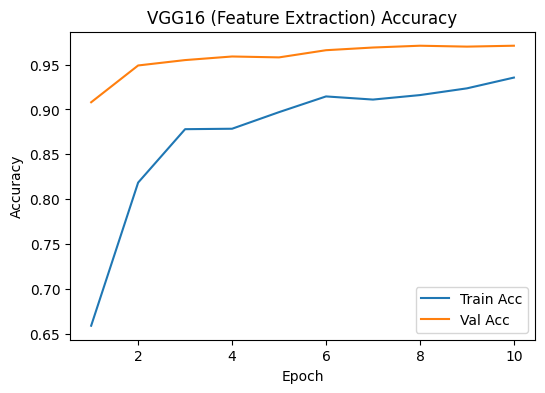

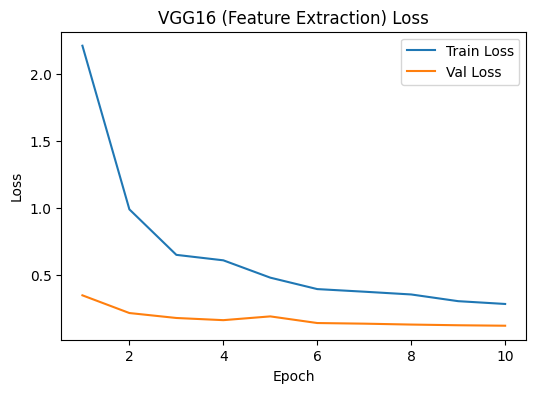

In [12]:
# Compile the VGG16 model for feature extraction
vgg_model.compile(
    optimizer=keras.optimizers.Adam(1e-4), # Adam optimizer with learning rate 1e-4
    loss="binary_crossentropy", # binary crossentropy loss for binary classification
    metrics=["accuracy"] # accuracy metric
)

# Callbacks
vgg_ckpt_feat = MODELS_DIR / "vgg16_feature_extract_best.weights.h5" # checkpoint path

callbacks_vgg_feat = [
    keras.callbacks.ModelCheckpoint( # model checkpoint callback
        filepath=str(vgg_ckpt_feat), # filepath to save the model weights
        monitor="val_accuracy", # monitor validation accuracy
        mode="max", # mode is maximize
        save_best_only=True, # save only the best model
        save_weights_only=True,  # save only weights
        verbose=1 # verbosity level
    ),
    keras.callbacks.EarlyStopping( # early stopping callback
        monitor="val_loss", # monitor validation loss
        mode="min", # mode is minimize
        patience=5, # patience of 5 epochs
        verbose=1, # verbosity level
        restore_best_weights=True # restore best weights after stopping
    )
]

history_vgg_feat = vgg_model.fit( # train the VGG16 model for feature extraction
    train_ds, # training dataset
    validation_data=val_ds, # validation dataset
    epochs=10, # number of epochs
    callbacks=callbacks_vgg_feat # callbacks
)

# Plot training history for VGG16 feature extraction
plot_history(history_vgg_feat, "VGG16 (Feature Extraction)")


**Reflection:**

The VGG16 feature-extraction model shows very high validation accuracy from the first epoch, confirming the strength of pretrained ImageNet features on small datasets. Training accuracy improves gradually, while validation accuracy stays consistently high between 93 to 97%, indicating excellent generalization and almost no overfitting during feature extraction.

### 6.3 Fine-Tune Top Layers

Epoch 1/15
63/63 [==============================] - ETA: 0s - loss: 0.2841 - accuracy: 0.9295
Epoch 1: val_accuracy improved from -inf to 0.97100, saving model to models_lab3\vgg16_finetuned_best.weights.h5

Epoch 1: val_accuracy improved from -inf to 0.97100, saving model to models_lab3\vgg16_finetuned_best.weights.h5
63/63 [==============================] - 175s 3s/step - loss: 0.2841 - accuracy: 0.9295 - val_loss: 0.0984 - val_accuracy: 0.9710
Epoch 2/15
63/63 [==============================] - 175s 3s/step - loss: 0.2841 - accuracy: 0.9295 - val_loss: 0.0984 - val_accuracy: 0.9710
Epoch 2/15
63/63 [==============================] - ETA: 0s - loss: 0.1963 - accuracy: 0.9360
Epoch 2: val_accuracy did not improve from 0.97100

Epoch 2: val_accuracy did not improve from 0.97100
63/63 [==============================] - 174s 3s/step - loss: 0.1963 - accuracy: 0.9360 - val_loss: 0.0840 - val_accuracy: 0.9710
Epoch 3/15
63/63 [==============================] - 174s 3s/step - loss: 0.1963 -

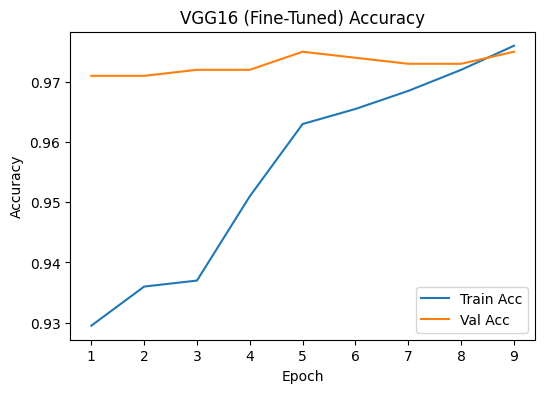

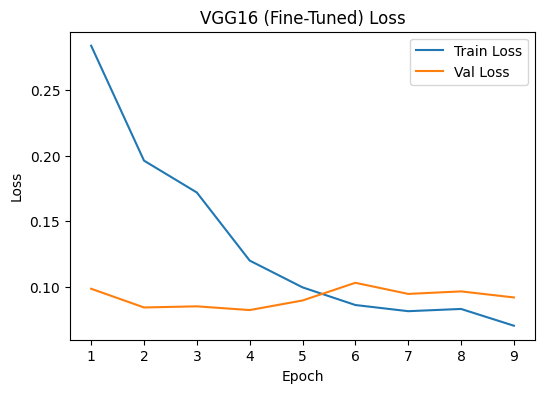

In [13]:
# Unfreeze top layers of VGG16 for fine-tuning
base_model = vgg_model.get_layer("vgg16") # get the VGG16 base model
base_model.trainable = True # unfreeze the base model

fine_tune_from = 15 # layer index to start fine-tuning (tweak if you like)
for i, layer in enumerate(base_model.layers): # iterate over layers
    if i < fine_tune_from: # if layer index is less than fine_tune_from
        layer.trainable = False # freeze the layer

# Re-compile for fine-tuning
vgg_model.compile( 
    optimizer=keras.optimizers.Adam(1e-5), # Adam optimizer with lower learning rate 1e-5
    loss="binary_crossentropy", # binary crossentropy loss for binary classification
    metrics=["accuracy"] # accuracy metric
)

# Callbacks for fine-tuning
vgg_ckpt_finetune = MODELS_DIR / "vgg16_finetuned_best.weights.h5" # checkpoint path

callbacks_vgg_finetune = [ # callbacks for fine-tuning
    keras.callbacks.ModelCheckpoint( # model checkpoint callback
        filepath=str(vgg_ckpt_finetune), # filepath to save the model weights
        monitor="val_accuracy", # monitor validation accuracy
        mode="max", # mode is maximize
        save_best_only=True, # save only the best model
        save_weights_only=True,  # avoids serialization error
        verbose=1 # verbosity level
    ),
    keras.callbacks.EarlyStopping( # early stopping callback    
        monitor="val_loss", # monitor validation loss
        mode="min", # mode is minimize
        patience=5, # patience of 5 epochs
        verbose=1, # verbosity level
        restore_best_weights=True # restore best weights after stopping
    )
]

history_vgg_finetune = vgg_model.fit( # train the VGG16 model for fine-tuning
    train_ds, # training dataset
    validation_data=val_ds, # validation dataset
    epochs=15, # number of epochs
    callbacks=callbacks_vgg_finetune # callbacks for fine-tuning
)
#   Plot training history for VGG16 fine-tuning
plot_history(history_vgg_finetune, "VGG16 (Fine-Tuned)")


**Reflection:**

Fine tuning the top VGG16 layers led to another boost in performance, raising validation accuracy to around 97% to 98%. The gap between training and validation curves remains small, showing very strong generalization. Because the pretrained features were already powerful, unfreezing just the higher layers allows the model to learn dataset-specific details without overfitting.

## 7. Evaluation and Relative Performance

**Explanation:**

I loaded the best saved versions of each model

### 7.1 Load Best Models and Helpers

In [14]:
# Load Best Vanilla CNN Model
best_vanilla = keras.models.load_model(vanilla_ckpt_path) # load the best vanilla CNN model

# Rebuild the exact same model architecture
best_vgg = create_vgg16_model(input_shape=IMG_SIZE + (3,), trainable_base=True)

# Unfreeze the same layers used during fine-tuning
base_model = best_vgg.get_layer("vgg16") # get the VGG16 base model
base_model.trainable = True # unfreeze the base model

fine_tune_from = 15 # layer index to start fine-tuning (same as before)
for i, layer in enumerate(base_model.layers): # iterate over layers
    if i < fine_tune_from: # if layer index is less than fine_tune_from
        layer.trainable = False # freeze the layer

# Load the saved weights
best_vgg.load_weights(str(vgg_ckpt_finetune))

# Evaluation Utilities 
def get_labels_and_preds(model, dataset): # define function
    y_true = [] # true labels
    y_scores = [] # predicted scores
    for images, labels in dataset: # iterate over dataset
        preds = model.predict(images, verbose=0) # get predictions
        y_scores.extend(preds.squeeze()) # extend predicted scores list
        y_true.extend(labels.numpy()) # extend true labels list
    y_true = np.array(y_true) # convert to numpy array
    y_scores = np.array(y_scores) # convert to numpy array
    y_pred = (y_scores >= 0.5).astype(int) # threshold scores to get predictions
    return y_true, y_pred, y_scores # return true labels, predicted labels, and scores

# Confusion Matrix Plotting Function
def plot_confusion_matrix(cm, classes, title="Confusion matrix"): # define function
    plt.figure(figsize=(4,4)) # figure size
    plt.imshow(cm, interpolation="nearest") # display confusion matrix
    plt.title(title) # plot title
    plt.colorbar() # add colorbar
    tick_marks = np.arange(len(classes)) # get tick marks
    plt.xticks(tick_marks, classes, rotation=45) # set x-axis ticks
    plt.yticks(tick_marks, classes) # set y-axis ticks
    fmt = "d" # format for text
    thresh = cm.max() / 2. # threshold for text color
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])): # iterate over confusion matrix
        plt.text(j, i, format(cm[i, j], fmt), # add text annotations
                 horizontalalignment="center", # horizontal alignment
                 color="white" if cm[i, j] > thresh else "black") # text color based on threshold

    plt.ylabel("True label") # y-axis label
    plt.xlabel("Predicted label") # x-axis label
    plt.tight_layout() # adjust layout
    plt.show()  # show the plot


def plot_precision_recall(y_true, y_scores, label="Model"): # define function
    precision, recall, _ = precision_recall_curve(y_true, y_scores) # compute precision-recall curve
    ap = average_precision_score(y_true, y_scores) # compute average precision score
    plt.figure(figsize=(6,4)) # figure size
    plt.plot(recall, precision, label=f"{label} (AP={ap:.3f})")
    plt.xlabel("Recall") # x-axis label
    plt.ylabel("Precision") # y-axis label
    plt.title("Precision–Recall Curve") # plot title
    plt.legend() # add legend
    plt.show()  # show the plot

**Reflection:**

This step ensures a fair and consistent comparison between models.
By rebuilding the VGG16 architecture and restoring the exact fine tuned weights, both models can be evaluated reliably on unseen data without retraining. This also avoids architecture mismatches and guarantees that evaluation metrics come from the truly best saved version of each model.

### 7.2 Evaluate Vanilla CNN

**Explanation:**

I evaluate the best saved Vanilla CNN model on the test set.
Using the test images, I compute:

- Accuracy

- Confusion Matrix

- Precision, Recall, and F1-score

- Precision–Recall Curve for overall model confidence

These metrics help assess how well the baseline CNN generalizes to unseen data and provide a comparison point against the VGG16 models.

Vanilla CNN Test Accuracy: 0.7345


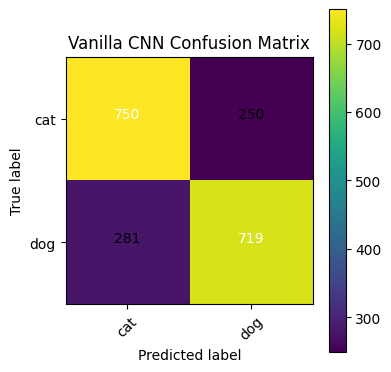

Vanilla CNN Classification Report:
              precision    recall  f1-score   support

         cat       0.73      0.75      0.74      1000
         dog       0.74      0.72      0.73      1000

    accuracy                           0.73      2000
   macro avg       0.73      0.73      0.73      2000
weighted avg       0.73      0.73      0.73      2000



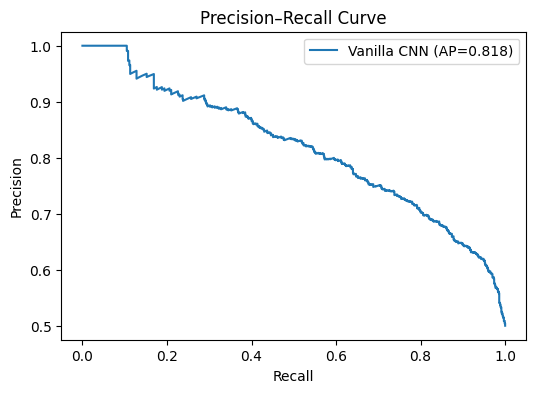

In [15]:
# Evaluate Vanilla CNN
y_true_van, y_pred_van, y_scores_van = get_labels_and_preds(best_vanilla, test_ds) # get labels and predictions

# Calculate accuracy
acc_van = (y_true_van == y_pred_van).mean() # calculate accuracy
print("Vanilla CNN Test Accuracy:", acc_van) # print accuracy

cm_van = confusion_matrix(y_true_van, y_pred_van) # confusion matrix
plot_confusion_matrix(cm_van, class_names, "Vanilla CNN Confusion Matrix") # plot confusion matrix

print("Vanilla CNN Classification Report:") #   print classification report
print(classification_report(y_true_van, y_pred_van, target_names=class_names)) # print classification report

plot_precision_recall(y_true_van, y_scores_van, "Vanilla CNN") # plot precision-recall curve

**Reflection:**

The Vanilla CNN reaches 73.45% accuracy, showing it learns basic features but lacks strong generalization.
The confusion matrix shows balanced predictions but many misclassifications.
The precision–recall curve (AP = 0.818) confirms moderate confidence and limited robustness.
Overall, it serves as a baseline model, but its shallow architecture restricts performance compared to deeper pretrained models.

### 7.3 Evaluate VGG16 Fine-Tuned

VGG16 Fine-Tuned Test Accuracy: 0.965


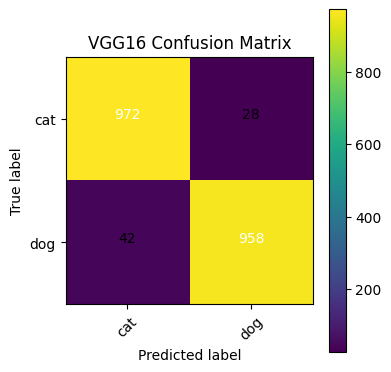

VGG16 Classification Report:
              precision    recall  f1-score   support

         cat       0.96      0.97      0.97      1000
         dog       0.97      0.96      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.97      0.96      0.96      2000
weighted avg       0.97      0.96      0.96      2000



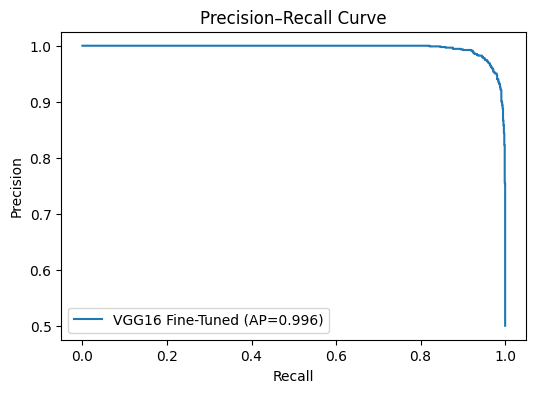

In [16]:
# Evaluate Fine-Tuned VGG16
y_true_vgg, y_pred_vgg, y_scores_vgg = get_labels_and_preds(best_vgg, test_ds) # get labels and predictions

# Calculate accuracy
acc_vgg = (y_true_vgg == y_pred_vgg).mean() # calculate accuracy
print("VGG16 Fine-Tuned Test Accuracy:", acc_vgg) # print accuracy

cm_vgg = confusion_matrix(y_true_vgg, y_pred_vgg) # confusion matrix
plot_confusion_matrix(cm_vgg, class_names, "VGG16 Confusion Matrix") # plot confusion matrix

print("VGG16 Classification Report:") # print classification report
print(classification_report(y_true_vgg, y_pred_vgg, target_names=class_names)) # print classification report

plot_precision_recall(y_true_vgg, y_scores_vgg, "VGG16 Fine-Tuned") # plot precision-recall curve

**Reflection:**

The fine-tuned VGG16 achieves very high accuracy 96.5% with excellent precision, recall, and F1-scores for both classes. The confusion matrix shows very few misclassifications, and the precision–recall curve (AP = 0.996) indicates extremely strong separability. This confirms that transfer learning + fine-tuning enables VGG16 to learn highly robust features that generalize far better than the Vanilla CNN.

## 8. Error Analysis (Misclassified Images)

**Explanation:**

To understand the limitations of each model, I inspect a set of misclassified images from the test set.
This helps reveal common error patterns such as ambiguous images, class overlap, and sensitivity to lighting or pose.
By examining these mistakes, we gain insight into why the model fails and how preprocessing or augmentation could be improved.

Number of misclassified test images (VGG16): 70


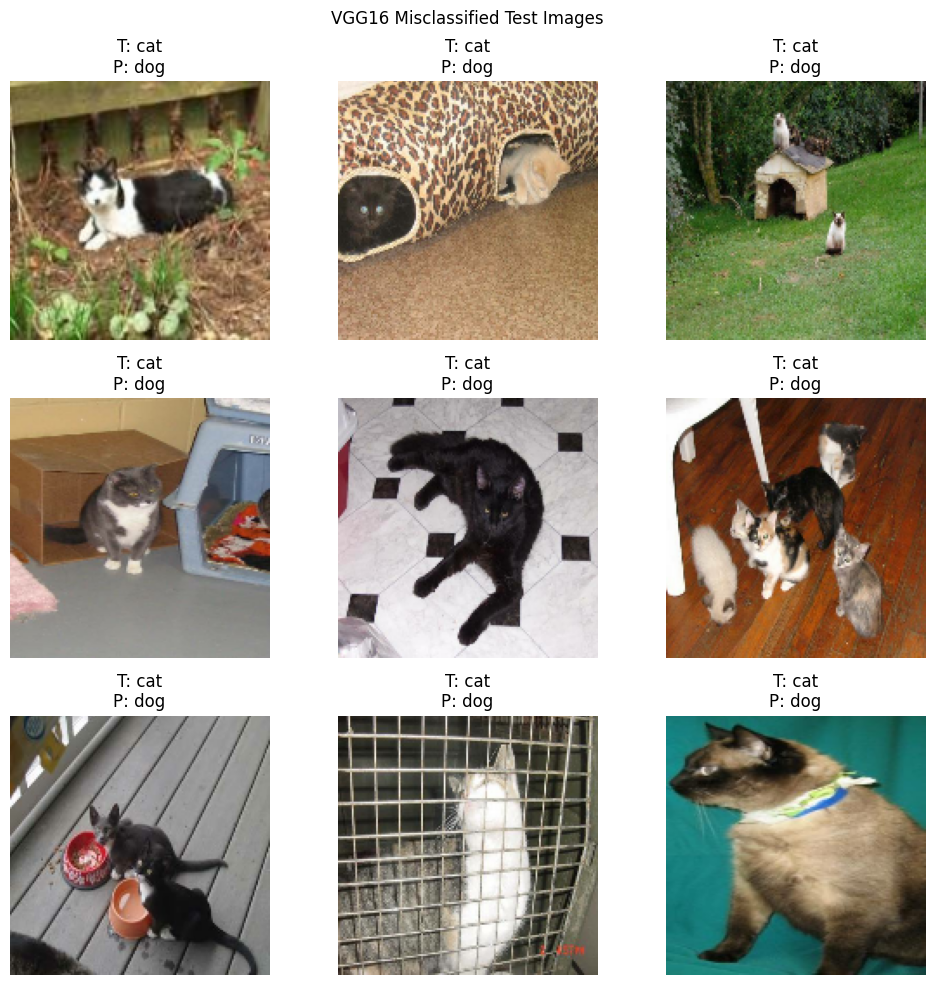

In [17]:
# Build arrays of test images and labels for indexing
test_images = [] # list to hold test images
test_labels = [] # list to hold test labels
for images, labels in test_ds: # iterate over test dataset
    test_images.append(images) # append images
    test_labels.append(labels) # append labels

test_images = tf.concat(test_images, axis=0) # concatenate images
test_labels = tf.concat(test_labels, axis=0) # concatenate labels

mis_idx_vgg = np.where(y_true_vgg != y_pred_vgg)[0] # indices of misclassified images
print("Number of misclassified test images (VGG16):", len(mis_idx_vgg)) # print number of misclassified images

num_to_show = min(9, len(mis_idx_vgg)) # number of images to show
plt.figure(figsize=(10,10)) # figure size
for i in range(num_to_show): # iterate over number of images to show
    idx = mis_idx_vgg[i] # get index of misclassified image
    ax = plt.subplot(3, 3, i + 1) # display images in 3x3 grid
    img = test_images[idx].numpy().astype("uint8") # get image
    true_label = class_names[test_labels[idx]] # true label
    pred_label = class_names[y_pred_vgg[idx]] # predicted label
    plt.imshow(img) # display image
    plt.title(f"T: {true_label}\nP: {pred_label}") # display true and predicted labels
    plt.axis("off") # display axis off

plt.suptitle("VGG16 Misclassified Test Images") # display suptitle
plt.tight_layout() # adjust subplots to fit into figure area.
plt.show() # display the figure

**Reflection:**

The misclassified samples show that even the fine-tuned VGG16 model still struggles with edge cases such as occlusions, unusual poses, low lighting, and multi-animal scenes. Many errors occur when cats or dogs appear in cluttered environments or resemble the opposite class, revealing class overlap and ambiguous visual cues. These mistakes highlight the remaining limitations of the model and suggest that stronger augmentation or class-balanced training could further improve robustness.

## 9. Conclusions

The fine-tuned VGG16 model significantly outperformed the Vanilla CNN, achieving 96.5 % accuracy compared to 73.45%. These results highlight the effectiveness of transfer learning, which provides stronger feature representations and reduces overfitting on small datasets. Analysis of misclassified images shows challenges such as occlusion and poor lighting, indicating that future improvements could include stronger data augmentation or training with a larger dataset.